# Modeling depression using Classification

#### Question 1: can depression be predicted based on X,Y,Z?

#### Question 3: what are the students that need the highest help? How can we help them? What exists in India to prevent this?

In [4]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) 
plt.rcParams['font.size'] = 14

In [6]:
df = pd.read_csv("depression_after_eda.csv")
df.applymap(type).eq(str).any() #to check which column in the dataset contains string values

Gender                 True
Age                   False
City                   True
Academic Pressure     False
CGPA                  False
Study Satisfaction    False
Sleep Duration         True
Dietary Habits         True
Degree                 True
Suicidal Thoughts      True
Work_study_hours      False
Financial Stress      False
Family History         True
Depression            False
dtype: bool

In [7]:
#for now we take out degree and cities, because harder to factorise and not sure if very relevant
print(df["Degree"].nunique())
print(df["City"].nunique())

28
52


In [8]:
#I exclude City and Degree for now
X = df[["Gender","Age","Academic Pressure","CGPA","Study Satisfaction", "Sleep Duration","Dietary Habits","Suicidal Thoughts", "Work_study_hours","Financial Stress", "Family History"]]
y = df["Depression"]

In [9]:
#the two classes do not seem imbalances
print(y.value_counts(normalize=True))

Depression
1    0.585499
0    0.414501
Name: proportion, dtype: float64


In [10]:
#I first create numerical categories for all non-numerical features I want to retain: 
#Gender, Sleep Duration, Dietary Habits, Suicidal Thoughts, Family History
X["Gender"]=X["Gender"].map({"Male":0,"Female":1})
X["Sleep Duration"]=X["Sleep Duration"].factorize()[0] #to simplify with categories
X["Dietary Habits"]=X["Dietary Habits"].factorize()[0]
X["Suicidal Thoughts"]=X["Suicidal Thoughts"].map({"Yes":1,"No":0})
X["Family History"]=X["Family History"].map({"Yes":1,"No":0})

# I then perform a one-hot encoding on the categorical variables I factorised.
X = pd.get_dummies(columns=["Gender", "Sleep Duration", "Dietary Habits", "Suicidal Thoughts", "Family History"], drop_first=True, data=X)

<ipython-input-10-634a1fa28c87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Gender"]=X["Gender"].map({"Male":0,"Female":1})
<ipython-input-10-634a1fa28c87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Sleep Duration"]=X["Sleep Duration"].factorize()[0] #to simplify with categories
<ipython-input-10-634a1fa28c87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [11]:
# 1st hold-out technique: train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=52, stratify=y)

### K-Nearest Neighbours

In [ ]:
#I define the following pipeline with StandardScaler and KNeighborsClassifier:
#1-StandardScaler standardizes our data by subtracting the mean from each feature and dividing by its standard deviation. 
#Scaling features is important given that Euclidean distance is used to compute the number of KNN

#When I call a pipeline the following happens under the hood automatically:
#StandardScaler().fit(X_train) — learns the mean and std from the training data
#StandardScaler().transform(X_train) — scales X_train using those parameters
#KNeighborsClassifier().fit(...) — trains on the scaled X_train
pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [ ]:
#tuning the model to understand when the testing error is minimised
k_range=list(range(1,101))
training_error=[]
testing_error=[]

for k in k_range:
    pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(k))])
    pipeline.fit(X_train, y_train)
    
    y_pred_class = pipeline.predict(X_test)
    testing_accuracy=metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1-testing_accuracy)
    
    y_pred_class = pipeline.predict(X_train)
    training_accuracy=metrics.accuracy_score(y_train, y_pred_class)
    training_error.append(1-training_accuracy)

In [ ]:
#k=12 is the value that minimises the testing error
knn_error = pd.DataFrame(list(zip(k_range, training_error, testing_error)), columns=["k","training_error","testing_error"])
knn_error.set_index("k").sort_values(by="testing_error", ascending=True)

In [ ]:
knn_error.set_index("k").sort_values(by="testing_error", ascending=True).plot();

In [ ]:
#computing the accuracy with k=94
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(94))])
pipeline_knn.fit(X_train, y_train)
y_pred_knn=pipeline_knn.predict(X_test)
print(f' The accuracy of the KNN model is: {metrics.accuracy_score(y_test, y_pred_knn):.4f}')

In [ ]:
#accuracy of the null model (most frequent class)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
print(f'The accuracy of the null model is: {dummy_clf.score(X_test, y_test):.3f}')

In [ ]:
#Confusion Matrix
class_names = ['depressed_no', 'depressed_yes']
ConfusionMatrixDisplay.from_estimator(pipeline.fit(X_train, y_train), X_test, y_test,
                                 display_labels=class_names, cmap=plt.cm.Blues);
plt.savefig("Confusion matrix from KNN", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
#classification report
print(metrics.classification_report(y_test, y_pred_knn))

In [ ]:
#the model is very good at ranking the positive cases (e.g. “depressed”) 
#higher than the negative cases (e.g. “not depressed”)
RocCurveDisplay.from_estimator(pipeline_knn, X_test, y_test);

In [ ]:
X_test["y_pred_knn"] = y_pred_knn
X_test["y"]=df.loc[X_test.index, "Depression"]
X_test["y_pred=y"] = X_test["y_pred_knn"] == X_test["y"]

In [ ]:
#accuracy of the model
X_test["y_pred=y"].value_counts(normalize=True)[0]

In [ ]:
#investigating false negative
false_negatives_knn=X_test[(X_test["y_pred_knn"]==0)&(X_test["y"]==1)]
false_negatives_knn.describe()

In [ ]:
true_positives = X_test[(X_test["y_pred_knn"]==1)&(X_test["y"]==1)]
true_positives.describe()

In [ ]:
#comparing histograms between FN and TP
columns = ["Age", "Academic Pressure", "CGPA", "Study Satisfaction", "Work_study_hours", "Financial Stress"]
for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(false_negatives_knn[column], bins=20, alpha=0.5, label='False Negatives', edgecolor="red", linewidth=2, histtype='step', fill=False, density=True)
    plt.hist(true_positives[column], bins=20, alpha=0.5, label='True Positives', edgecolor="green", linewidth=2, histtype='step', fill=False,  density=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Differences are driven by 1) age, 2)academic pressure, 3)study satisfaction, 4)financial stress.
# 1) true positives are younger, whereas false negatives are in general older;
# 2) true positives have a right-skewed distribution (more people feeling higher academic pressure)
# 3) true positives have a left-skewed distribution (less and less people feeling higher study satisfaction).
# 4) TP have a right-skewed distribution vs FN

In [ ]:
#True negatives and false positives
true_negatives_knn = X_test[(X_test["y_pred_knn"]==0)&(X_test["y"]==1)]
false_positives_knn = X_test[(X_test["y_pred_knn"]==1)&(X_test["y"]==0)]

In [ ]:
columns = ["Age", "Academic Pressure", "CGPA", "Study Satisfaction", "Work_study_hours", "Financial Stress"]
for column in columns:
    plt.figure(figsize=(8, 4))
    plt.hist(true_negatives_knn[column], bins=20, alpha=0.5, label='True Negative', edgecolor="blue", linewidth=2, histtype='step', fill=False, density=True)
    plt.hist(false_positives_knn[column], bins=20, alpha=0.5, label='False Positives', edgecolor="orange", linewidth=2, histtype='step', fill=False,  density=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#2nd hold-out technique: cross-validation:
#I average the five accuracy values I get for each fold)
kf = KFold(n_splits=5, shuffle=True, random_state=2023) #randomly shuffling the data
scores=cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')
print(f'The accuracy of the model using cross-validation is: {np.mean(scores):.4f}')


In [ ]:
y_pred_cross_val = cross_val_predict(pipeline, X, y, cv=kf)
cm = confusion_matrix(y, y_pred_cross_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix from Cross-Validation")
plt.show()

#this makes predictions for all samples, so 100% ofb the data, unlike train/test split
#which only focuses on test data.

#there are a lot of false positives - the model predicts that 3081 students are depressed while in fact they are not.

In [ ]:
#adding degrees and cities will increase accuracy?
X = df[["Gender","City","Degree","Age","Academic Pressure","CGPA","Study Satisfaction", "Sleep Duration","Dietary Habits","Suicidal Thoughts", "Work_study_hours","Financial Stress", "Family History"]]
X["City"] = X["City"].factorize()[0]
X["Degree"] = X["Degree"].factorize()[0]
X = pd.get_dummies(columns=["Gender", "City","Degree","Sleep Duration", "Dietary Habits", "Suicidal Thoughts", "Family History"], drop_first=True, data=X)

In [ ]:
#adding Degree and City reduces my accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=52, stratify=y)
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(94))])
pipeline_knn.fit(X_train, y_train)
y_pred_knn=pipeline_knn.predict(X_test)
print(f' The accuracy of the KNN model is: {metrics.accuracy_score(y_test, y_pred_knn):.4f}')

In [ ]:
#to check the best variable combination

# Recreate your full pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=94))
])

# Use forward selection to add features one at a time
sfs = SequentialFeatureSelector(pipeline, n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5, n_jobs=-1)

sfs.fit(X, y)

# See which features were selected
selected_features = X.columns[sfs.get_support()]
print("Best feature combination:", list(selected_features))

In [ ]:
#accuracy improves a bit more - from 0.839 to 0.845
X = df[["Age","Academic Pressure","Study Satisfaction","Dietary Habits","Suicidal Thoughts", "Work_study_hours","Financial Stress"]]
X["Dietary Habits"]=X["Dietary Habits"].factorize()[0]
X["Suicidal Thoughts"]=X["Suicidal Thoughts"].map({"Yes":1,"No":0})
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=52, stratify=y)
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(94))])
pipeline_knn.fit(X_train, y_train)
y_pred_knn=pipeline_knn.predict(X_test)
print(f' The accuracy of the KNN model is: {metrics.accuracy_score(y_test, y_pred_knn):.4f}')

### Logistic Regression
It seems to outperform KNN, as accuracy here is 83%!

In [ ]:
pipeline_logreg = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=51)
pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = pipeline_logreg.predict(X_test)
pipeline_logreg.score(X_test, y_test)

In [ ]:
class_names = ['depressed_no', 'depressed_yes']
ConfusionMatrixDisplay.from_estimator(pipeline_logreg, X_test, y_test,
                                 display_labels=class_names,
                                 cmap="Reds");
plt.title("Confusion Matrix");
plt.savefig("Confusion Matrix from logistic regression", dpi=300, bbox_inches="tight");
plt.show()

In [ ]:
metrics.RocCurveDisplay.from_estimator(pipeline_logreg, X_test, y_test);

In [ ]:
#X_test["y_pred_logreg"]=y_pred_logreg
X['y_pred_probabilities'] = pipeline_logreg.predict_proba(X)[:, 1]
#X_test["y"]=df.loc[X_test.index, "Depression"]
#X_test["y_pred_logreg = y"] = X_test["y_pred_logreg"] == X_test["y"]

In [ ]:
#I get higher accuracy if I don't scale the data -> fewer true negatives but more true positives.
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print(logreg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred_logreg))

#this is interesting, I get 0.85 accuracy. BUT WHY WHEN I SCALE THE DATA I GET A SLIGHTLY LOWER ACCURACY? 
#TO BE INVESTIGATED FURTHER

In [ ]:
logreg1=LogisticRegression(penalty='none', solver='lbfgs')  # if no scaling
logreg2=LogisticRegression(penalty='l2', solver='lbfgs') #if scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg1.fit(X_train, y_train)
y_pred_logreg1 = logreg1.predict(X_test)
print(logreg1.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred_logreg1))

np.mean(cross_val_score(logreg1, X, y, cv=5, scoring='accuracy'))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
logreg2.fit(X_train, y_train)
y_pred_logreg2 = logreg2.predict(X_test)
print(logreg2.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred_logreg2))

np.mean(cross_val_score(logreg2, X, y, cv=5, scoring='accuracy'))

In [ ]:
print(confusion_matrix(y_test, y_pred_logreg))

### Naive Bayes

### Decision Trees

 Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It models decisions and their possible consequences as a tree-like structure of if-then-else conditions, helping the algorithm learn patterns in the data to make predictions.
 
- The tree starts at the **root node**, which contains the full dataset.
- At each node, the algorithm selects the **best feature and threshold** to split the data into two or more branches. The goal is to maximize information gain (in classification) or reduce variance (in regression). For regression, the model picks the feature so that the resulting tree has the **lowest RMSE**. For classification, the model picks the feature that reduces the **Gini index** (from 0 to 0.5 -> when 0, the node is pure).
- This splitting process continues recursively until a stopping condition is met (e.g., max depth reached, or nodes are pure).
- The final output is a leaf node, which provides the prediction:
    - A class label in classification tasks,
    - A numerical value in regression tasks.
- Decision trees are not sensitive to the scale of the input features, so standardisation/normalisation 
is not required, unlike for KNN, logistic regression, linear regression, KMeans.

In [ ]:
max_depth_range = list(range(1,200))
testing_error=[]
training_error=[]

for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=52)
    treeclf.fit(X_train, y_train)
    y_pred_class = treeclf.predict(X_test)
    testing_accuracy=metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1-testing_accuracy)    
    
    y_pred_class = treeclf.predict(X_train)
    training_accuracy=metrics.accuracy_score(y_train, y_pred_class)
    training_error.append(1-training_accuracy)

In [ ]:
treeclf_error = pd.DataFrame(list(zip(max_depth_range, training_error, testing_error)), columns=["max_length","training_error","testing_error"])
treeclf_error.sort_values("testing_error")

#max_lenght=7 leads to the lowest testing error

In [ ]:
treeclf = DecisionTreeClassifier(random_state=1, max_depth=7)
treeclf.fit(X_train,y_train)

In [ ]:
y_pred = treeclf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.4f}')

In [ ]:
#Gini importance (impurity reduction): Suicidal Thoughts, Academic Pressure and Financial Stress.
pd.DataFrame({'feature':X.columns, 'importance':treeclf.feature_importances_}).sort_values("importance", ascending=False)

In [ ]:
export_graphviz(treeclf, out_file='Decision_Tree', feature_names=X.columns)

### Random Forest Model

A Random Forest is a supervised machine learning algorithm that consists of a collection (or “ensemble”) of many individual decision trees, typically trained using a method called bagging (each tree is trained on a randomly drawn subset of the training data, to increase diversity). It is used for both classification and regression tasks and is known for its accuracy, robustness, and ability to handle large datasets with high dimensionality.

The idea behind a random forest is **to reduce the risk of overfitting** that is often associated with a single decision tree, while maintaining high predictive performance. This is achieved by building many decision trees during training and combining their outputs to make a final prediction:
- For **classification**, it predicts the class that is the majority vote among all trees.
- For **regression**, it predicts the average of the outputs from all trees.

In [ ]:
#step 1:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10,random_state=52)

In [ ]:
#step 2: checking the best estimator
n_estimator_range = range(10, 300, 10)
mean_scores = []

for n in n_estimator_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=52)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())

In [ ]:
plt.plot(n_estimator_range, mean_scores);
plt.xlabel('n_estimators');
plt.ylabel('Cross-Validated Accuracy');
plt.title('Choosing n_estimators');

In [ ]:
#step 3: fitting the model
rf_model.fit(X_train, y_train)
y_pred_rf=rf_model.predict(X_test)

In [ ]:
#step 4: computing accuracy, metrics, confusion matrix.
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

#### Question 2: what are the most important predictors of depression?

In [ ]:
#feature importance: Suicidal Thoughts, Academic Pressure, CGPA, Age, Financial Stress

#It gives a relative ranking of the predictors based on how often and how effectively they are used 
#to split the data across all trees in the forest.
feature_importance = pd.DataFrame({"feature": X_train.columns,"importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)
feature_importance

In [ ]:
#using GridSearch to select the best parameters
from sklearn.model_selection import GridSearchCV

params = {"max_depth": [3, 5, 10, 20, 30], "n_estimators": [100, 150, 200, 250, 300]}
search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
search.fit(X_train, y_train)
print(search.best_params_)

### *I WANT TO EXAMINE FALSE NEGATIVES: PEOPLE THAT ARE DEPRESSED BUT CLASSIFIED AS NOT DEPRESSED*

### Gradient Boosting Machines (XGBoost, LightGBM, CatBoost)

#### XGBoost

XGBoost, short for eXtreme Gradient Boosting, is an open-source software library that provides an efficient and scalable implementation of gradient boosted decision trees. Gradient boosting is a machine learning technique that builds a strong predictive model by combining multiple "weak" models, typically decision trees, sequentially. Each new model attempts to correct the errors made by the preceding models, iteratively minimizing a loss function. XGBoost involves three main components: a loss function to be minimized, a weak learner to make predictions, and an additive model to add weak learners to minimize the loss function

https://medium.com/@weidagang/essential-python-for-machine-learning-xgboost-4b662cf19fcd

In [1]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [2]:
%pip install xgboost

  Using cached xgboost-2.1.4.tar.gz (1.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [63 lines of output]
      INFO:xgboost.packager.build_wheel:Parsed build configuration: {'hide_cxx_symbols': True, 'use_openmp': True, 'use_cuda': False, 'use_nccl': False, 'use_dlopen_nccl': False, 'plugin_federated': False, 'plugin_rmm': False, 'use_system_libxgboost': False}
      INFO:xgboost.packager.build_wheel:Copying project files to temporary directory /var/folders/l9/y4n2vq0n2vj1zbf2642c48lw0000gn/T/tmpiewj88l_/whl_workspace
      INFO:xgboost.packager.build_wheel:Copying /private/var/folders/l9/y4n2vq0n2vj1zbf2642c48lw0000gn/T/pip-install-0nhsnb2t/xgboost_f61ae86c9912436d91ce194c1b8ea3a4/pyproject.toml -> /var/folders/l9/y4n2vq0n2vj1zbf2642c48lw0000gn/T/tmpiewj88l_/whl

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb
print(xgb.__version__)

In [ ]:
!conda list xgboost

In [ ]:
!{sys.executable} -m pip uninstall -y xgboost
!{sys.executable} -m pip uninstall -y libxgboost

In [ ]:
import sys
!{sys.executable} -m pip install --force-reinstall --no-cache-dir xgboost

In [ ]:
import sys
print(sys.executable)

In [ ]:
#no need to scale the model
xgb_model = xgb.XGBClassifier(n_estimators=10)#HOW DO I CHANGE NUMBER OF ESTIMATORS??
pipeline_xgb.fit(X_train, y_train)
predictions_xgb = pipeline_xgb.predict(X_test)

In [ ]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print('y_test:', y_test)
print('predictions:', predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Feature importance
feature_importance = model.feature_importances_

# Plotting feature importance
plt.barh(iris.feature_names, feature_importance)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features with XGBoost')

In [ ]:
#hyperparameter tuning https://www.youtube.com/watch?v=wqnwm15bg7A

## Unsupervised Machine Learning

### 1. Clustering - see if certain groups of people are more prone to depression - then we compare clusters

## K-Means

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [14]:
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=1)

In [18]:
X["cluster_scaled"] = km.labels_
X

,Age,Academic Pressure,CGPA,Study Satisfaction,Work_study_hours,Financial Stress,Gender_1,Sleep Duration_1,Sleep Duration_2,Sleep Duration_3,Sleep Duration_4,Dietary Habits_1,Dietary Habits_2,Dietary Habits_3,Suicidal Thoughts_1,Family History_1,cluster_scaled
0,33,5.0,8.97,2.0,3.0,1.0,False,False,False,False,False,False,False,False,True,False,0
1,24,2.0,5.90,5.0,3.0,2.0,True,False,False,False,False,True,False,False,False,True,0
2,31,3.0,7.03,5.0,9.0,1.0,False,True,False,False,False,False,False,False,False,True,1
3,28,3.0,5.59,2.0,4.0,5.0,True,False,True,False,False,True,False,False,True,True,0
4,25,4.0,8.13,3.0,1.0,1.0,True,False,False,False,False,True,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,27,5.0,5.75,5.0,7.0,1.0,True,False,False,False,False,False,True,False,True,True,0
27897,27,2.0,9.40,3.0,0.0,3.0,False,True,False,False,False,False,False,False,False,True,1
27898,31,3.0,6.61,4.0,12.0,2.0,False,False,False,False,False,False,True,False,False,False,0
27899,18,5.0,6.88,2.0,10.0,5.0,True,True,False,False,False,False,False,False,True,False,1


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

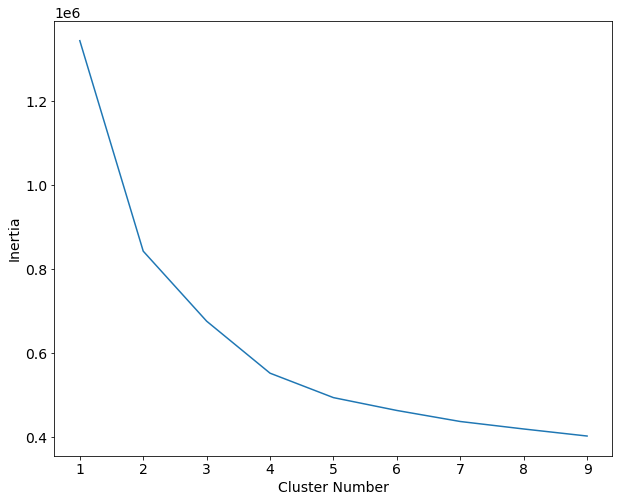

In [19]:
inertia_list = []
k_list = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    k_list.append(k)
    inertia_list.append(km.inertia_)
    
plt.plot(k_list, inertia_list)
plt.xlabel("Cluster Number")
plt.ylabel("Inertia")
plt.show();

In [20]:
km = KMeans(n_clusters=4, random_state=1)
km.fit(X_scaled)
km.labels_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 1, 1, ..., 2, 1, 1], dtype=int32)

In [21]:
centers=km.cluster_centers_

array([[-8.56619340e-03, -6.67704581e-02, -3.27753745e-02,
         2.29071098e-02, -8.40217634e-02, -1.94029643e-02,
        -1.30444311e-02, -6.51286700e-01, -5.97814881e-01,
         1.90166077e+00, -2.54077673e-02, -2.46004389e-03,
         2.09065170e-03, -1.27633930e-02, -1.13850355e-01,
        -9.62149035e-03],
       [ 4.79328305e-02, -4.65023619e-02,  1.04706507e-02,
         1.19604820e-03,  3.58772497e-03, -6.36987937e-02,
         4.84599750e-02,  1.81094942e-01,  1.48435624e-01,
        -5.25856143e-01, -2.54077673e-02,  4.36183135e-01,
        -7.65980789e-01,  1.77816312e-02, -4.17903039e-02,
        -5.27317171e-04],
       [-7.60849446e-02,  1.29352135e-01,  6.77294266e-03,
        -1.94761334e-02,  5.70478425e-02,  1.23995528e-01,
        -7.31997178e-02,  1.80248083e-01,  1.95816415e-01,
        -5.25856143e-01, -2.54077673e-02, -7.42818790e-01,
         1.30551577e+00, -2.07431234e-02,  1.56719886e-01,
         8.28424718e-03],
       [ 3.08022097e-01,  1.84250409e

#### DBSCAN

#### Agglomeration Clustering

### Dimensionality Reduction (PCA, t-SNE, UMAP). Goal: visualise high-dimensional data in 2D or 3D. Used to understand the structure of our data, or visualise clusters and how they relate to depression